# Multivariate Analysis of Sea Surface Temperature Using Lasso Regression

Within this notebook, I will be using multiple variables to predict sea surface air temperature (TAS) variability on decadal (>10 year) timescales. 

## Outline
- Loading the modules
- Loading our datasets for analysis.
- Looking at and understanding the data
- Preprocessing the data
- Creating and training the model
- Trying to predict coherence/interdecadal variability using our variables:
    - TAS alone
    - Water vapor path (PRW)
    - Vertical velocity ($\omega$)
  
  and doing analysis on our results.

# Loading the modules

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib
import gcsfs
import xesmf as xe
from scipy.interpolate import griddata
from xmip.preprocessing import rename_cmip6
from matplotlib import gridspec
from sklearn import linear_model
import cartopy as cart

# Loading the datasets

In [2]:
# Surface air temperature
tas = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_tas_piControl_2x2_48mod_last250.nc')
tas.load()

# Precipitable rain water
prw = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_prw_33model_piControl_2x2_last250.nc')
prw.load()

# Upward air velocity
omega = xr.open_dataarray('/data/keeling/a/mailes2/a/processed_var_data/250yeardatasets/CMIP_wap_37model_piControl_2x2_last250.nc')
omega.load()

<xarray.DataArray 'wap' (name: 37, time: 3000, lat: 88, lon: 179)>
array([[[[-1.30582080e-03, -1.34968237e-03, -1.39277443e-03, ...,
          -1.09849891e-03, -1.15495463e-03, -1.20851364e-03],
         [-5.72876215e-03, -6.49385769e-03, -7.15880888e-03, ...,
          -5.45577828e-03, -5.51601057e-03, -5.58140944e-03],
         [-6.41019277e-03, -6.72589964e-03, -7.31600262e-03, ...,
          -8.38972793e-03, -7.66306615e-03, -6.89528077e-03],
         ...,
         [ 2.26327154e-04, -1.54667218e-03, -3.06401914e-03, ...,
           1.44255413e-02,  1.27435834e-02,  1.07207373e-02],
         [ 3.90495094e-03,  3.22538794e-03,  2.93851341e-03, ...,
           6.71240387e-03,  6.03057037e-03,  5.36576174e-03],
         [ 1.80875878e-03,  1.96981108e-03,  2.11805073e-03, ...,
           1.18594440e-03,  1.33851866e-03,  1.49306122e-03]],

        [[ 1.65819250e-02,  1.58691623e-02,  1.51599958e-02, ...,
           1.93671283e-02,  1.86804128e-02,  1.79876838e-02],
         [-9.95225896e-04, -2.48268571e-03, -3.77618207e-03, ...,
           1.75826643e-03,  1.09275826e-03,  4.18689416e-04],
         [-1.13111619e-03, -1.81139933e-03, -2.57286936e-03, ...,
          -5.17841103e-04, -4.37318929e-04, -3.37238866e-04],
...
         [-1.98769169e-02, -3.14055122e-02, -3.18921730e-02, ...,
          -1.71963633e-02, -1.72390845e-02, -1.74638019e-02],
         [-1.21975748e-02, -1.58672701e-02, -1.81626710e-02, ...,
          -8.21450236e-03, -8.33693380e-03, -9.92146938e-03],
         [ 3.16954523e-03,  3.13328870e-03,  2.49478093e-03, ...,
           3.75857562e-03,  3.68311102e-03,  3.21851645e-03]],

        [[-1.11952340e-02, -1.11558221e-02, -1.13127520e-02, ...,
          -1.31718123e-02, -1.31009861e-02, -1.12948071e-02],
         [-1.38305952e-02, -1.31441024e-02, -1.27632879e-02, ...,
          -2.11460986e-02, -2.10708277e-02, -1.80237978e-02],
         [-6.10450632e-04, -2.11731764e-03, -2.16691289e-03, ...,
          -8.29885469e-03, -8.13230523e-03, -7.65083462e-03],
         ...,
         [ 2.80733770e-02,  2.07447410e-02,  2.05285666e-02, ...,
           1.33627220e-02,  1.30297856e-02,  1.33914570e-02],
         [ 3.27997319e-02,  3.06377565e-02,  2.89965165e-02, ...,
           3.06238895e-02,  3.05339838e-02,  3.12465616e-02],
         [ 3.23604289e-02,  3.22650904e-02,  2.93636285e-02, ...,
           3.32039166e-02,  3.25961076e-02,  3.23433559e-02]]]])
Coordinates:
    plev     float64 5e+04
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'GFDL-CM4' 'GFDL-ESM4' ... 'EC-Earth3-CC' 'E3SM-1-0'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   time: mean
    interp_method:  conserve_order2
    long_name:      omega (=dp/dt)
    original_name:  wap
    standard_name:  lagrangian_tendency_of_air_pressure
    units:          Pa s-1

We're using 3 different variables to test against TAS variability:
- TAS 
- PRW
- $\omega$


Each dataset has 4 dimensions:
- time (3000) - Each dataset is monthly over the last 250 years of piControl run time. 
- lat (88) - Latitude
- lon (179) - Longitude
- name (varying) - Models used

# Looking at and understanding the data

The datasets all have a different amount of models used, so I'll be picking out the models that are common between all of them.

In [3]:
models = ['ACCESS-CM2','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2','CESM2-WACCM',
          'CESM2-WACCM-FV2','CIESM','CMCC-CM2-SR5','E3SM-1-0','EC-Earth3','EC-Earth3-Veg-LR','FGOALS-g3','GFDL-CM4','GFDL-ESM4',
          'GISS-E2-1-G','INM-CM4-8','INM-CM5-0','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR','MRI-ESM2-0','NorCPM1','NorESM2-MM',
          'SAM0-UNICON','TaiESM1']

tas_trunc = tas.sel(name=models)
prw_trunc = prw.sel(name=models)
omega_trunc = omega.sel(name=models)

In [5]:
omega_trunc

<xarray.DataArray 'wap' (name: 29, time: 3000, lat: 88, lon: 179)>
array([[[[-2.61017622e-02, -2.48941791e-02, -2.42355267e-02, ...,
          -1.42593322e-02, -1.70810958e-02, -1.97603670e-02],
         [-2.04919179e-02, -2.19980299e-02, -2.12058648e-02, ...,
          -1.86288302e-02, -2.08892350e-02, -2.01774642e-02],
         [-1.69271199e-02, -1.50377277e-02, -1.41574423e-02, ...,
          -1.67886218e-02, -1.72370911e-02, -1.93833202e-02],
         ...,
         [-2.61668136e-03, -2.71082848e-03, -2.59055297e-03, ...,
          -3.93943866e-03, -3.43378335e-03, -2.63308167e-03],
         [-2.06061949e-03, -1.88343525e-03, -1.86340759e-03, ...,
          -1.25723282e-03, -1.56548619e-03, -1.73744708e-03],
         [ 5.62093278e-03,  5.43734372e-03,  5.66570461e-03, ...,
           6.57480886e-03,  6.47350897e-03,  6.07116908e-03]],

        [[ 1.50905372e-02,  1.53039441e-02,  1.46525597e-02, ...,
           2.03527874e-02,  1.89720228e-02,  1.78392363e-02],
         [-2.53449281e-03, -2.95715630e-03, -2.63822327e-03, ...,
          -3.07979633e-03, -3.74456743e-03, -3.67202461e-03],
         [-1.96104391e-02, -1.88028798e-02, -1.83208282e-02, ...,
          -1.52810268e-02, -1.70871844e-02, -1.84431177e-02],
...
         [-2.10389587e-03,  4.86037155e-04,  2.78814481e-03, ...,
           1.38192681e-03, -2.87625710e-03, -4.51255406e-03],
         [-8.99576065e-04, -7.72845347e-04, -8.39155801e-04, ...,
          -2.31072482e-03, -1.56060759e-03, -1.31857433e-03],
         [-1.44392501e-02, -1.34361001e-02, -1.24048466e-02, ...,
          -1.73738202e-02, -1.67820647e-02, -1.60973094e-02]],

        [[ 3.38363180e-02,  3.35607837e-02,  3.29873024e-02, ...,
           3.39707377e-02,  3.37903082e-02,  3.37683752e-02],
         [ 3.33577824e-02,  3.32361272e-02,  3.32816598e-02, ...,
           3.53077248e-02,  3.47082522e-02,  3.40528930e-02],
         [ 1.88023906e-02,  2.24198135e-02,  2.50180323e-02, ...,
           9.34909887e-03,  8.96335413e-03,  1.11837466e-02],
         ...,
         [-2.80247557e-02, -2.49866650e-02, -2.18777907e-02, ...,
          -2.71080565e-02, -3.01259342e-02, -3.11878665e-02],
         [-1.29602448e-02, -1.19795538e-02, -1.08297286e-02, ...,
          -1.54220056e-02, -1.51030266e-02, -1.45620276e-02],
         [-7.77165373e-03, -7.68571132e-03, -7.47575752e-03, ...,
          -7.56850645e-03, -7.77084027e-03, -7.80639853e-03]]]])
Coordinates:
    plev     float64 5e+04
  * time     (time) datetime64[ns] 1851-01-31 1851-02-28 ... 2100-12-31
  * lat      (lat) int64 -87 -85 -83 -81 -79 -77 -75 ... 75 77 79 81 83 85 87
  * lon      (lon) int64 1 3 5 7 9 11 13 15 ... 343 345 347 349 351 353 355 357
  * name     (name) object 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'TaiESM1'
Attributes:
    cell_measures:  area: areacella
    cell_methods:   time: mean
    interp_method:  conserve_order2
    long_name:      omega (=dp/dt)
    original_name:  wap
    standard_name:  lagrangian_tendency_of_air_pressure
    units:          Pa s-1

Here's what each dataset looks like averaged over time and model. For comparison, we have decadal TS variability, our desired output, as the last plot.

In [4]:
# Decadal TS Variability

tas_roll = tas.rolling(time=120, center=True).mean('time') # Our data is monthly, so for a decade we need 120 timesteps
tas_var = tas_roll.std('time') # Taking the standard deviation to get the variability

Text(0.5, 1.0, 'Decadal TAS variability (N=29)')

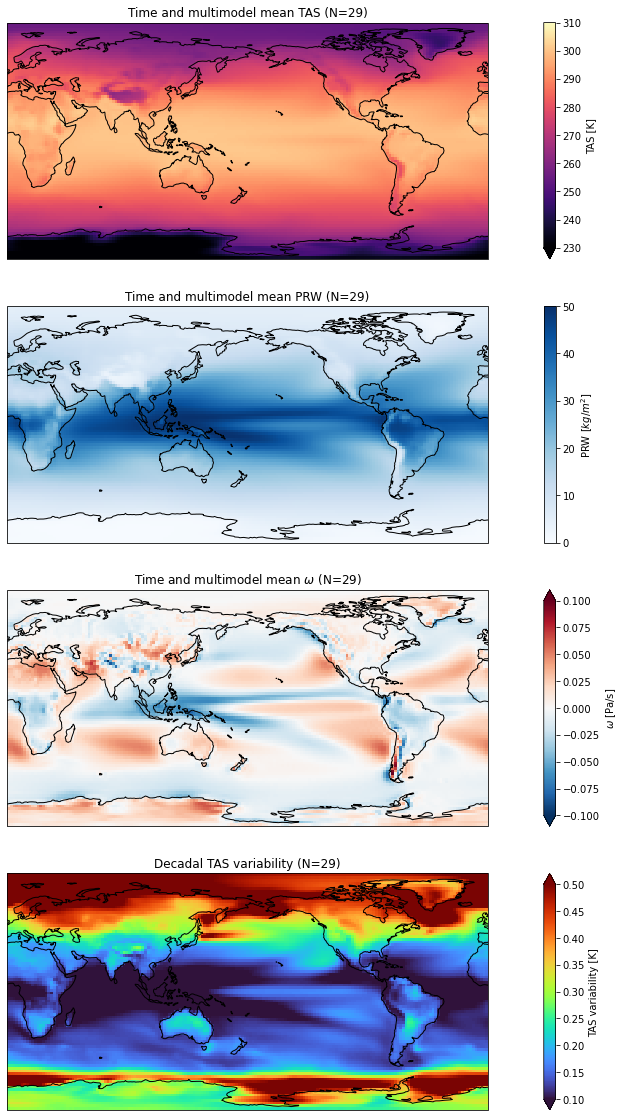

In [14]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

ax1 = fig.add_subplot(4,1,1, projection=ccrs.PlateCarree(central_longitude=180))
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_trunc.mean('time').mean('name').plot(ax=ax1, transform=ccrs.PlateCarree(), cmap='magma', vmin=230, vmax=310, 
                                         cbar_kwargs={'label': "TAS [K]"})
ax1.coastlines(color='black', linewidth=1)
plt.title('Time and multimodel mean TAS (N=29)')

ax2 = fig.add_subplot(4,1,2, projection=ccrs.PlateCarree(central_longitude=180))
#ax2.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
prw_trunc.mean('time').mean('name').plot(ax=ax2, transform=ccrs.PlateCarree(), cmap='Blues', vmin=0, vmax=50, 
                                         cbar_kwargs={'label': r"PRW [$kg/m^2$]"})
ax2.coastlines(color='black', linewidth=1)
plt.title('Time and multimodel mean PRW (N=29)')

ax3 = fig.add_subplot(4,1,3, projection=ccrs.PlateCarree(central_longitude=180))
#ax3.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
omega_trunc.mean('time').mean('name').plot(ax=ax3, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmin=-0.1, vmax=0.1,
                                           cbar_kwargs={'label': r"$\omega$ [Pa/s]"})
ax3.coastlines(color='black', linewidth=1)
plt.title(r'Time and multimodel mean $\omega$ (N=29)')

ax4 = fig.add_subplot(4,1,4, projection=ccrs.PlateCarree(central_longitude=180))
#ax.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_var.mean('name').plot(ax=ax4, transform=ccrs.PlateCarree(), cmap='turbo', vmin=0.1, vmax=0.5, 
                          cbar_kwargs={'label': "TAS variability [K]"})
ax4.coastlines(color='black', linewidth=1)
plt.title('Decadal TAS variability (N=29)')

Notice the dark blue pattern in the tropics! We want to understand and replicate this pattern.

# Pre-processing the data

We want to predict decadal time variability of TAS on spatial scales, which means that the data we want to give to our model should be spatial as well. 

Our data currently has dimensions of time x model x lat x lon. So, to make our data just in terms of lat x lon, we'll be taking time and model averages.

Additionally, in order to do our analysis, we'll be using Least Absolute Shrinkage and Selection Operator (LASSO) regression. 

I'll be using the sklearn function linear_model.Lasso(), which requires any datasets passed in to be 1-D. 

To turn our 2-D data (in terms of lat x lon), I'll use xr.stack to make my 2-D datasets into 1-D. I'll need to convert any predictions from the LASSO regression model from 1-D to 2-D later as well.

In [5]:
# Input data
tas_mean = tas_trunc.mean('time')
tas_mean_stack = tas_mean.stack(z=('lat','lon'))

prw_mean = prw_trunc.mean('time')
prw_stack = prw_mean.stack(z=('lat','lon'))

omega_mean = omega_trunc.mean('time')
omega_stack = omega_mean.stack(z=('lat','lon'))

# Output data
tas_var_stack = tas_var.stack(z=('lat','lon'))

For our regression, we'll want data to train it with and then test our predictions on. Since we have 29 models, I'll take the first 24 models to be our training set, and the last 5 models to be our testing set.

In [6]:
# Separate the data into training and testing data

train_mod = ['ACCESS-CM2','AWI-CM-1-1-MR','BCC-CSM2-MR','BCC-ESM1','CAMS-CSM1-0','CanESM5','CESM2','CESM2-FV2','CESM2-WACCM',
          'CESM2-WACCM-FV2','CIESM','CMCC-CM2-SR5','E3SM-1-0','EC-Earth3','EC-Earth3-Veg-LR','FGOALS-g3','GFDL-CM4','GFDL-ESM4',
          'GISS-E2-1-G','INM-CM4-8','INM-CM5-0','MIROC6','MPI-ESM1-2-HR','MPI-ESM1-2-LR']

test_mod = ['MRI-ESM2-0','NorCPM1','NorESM2-MM','SAM0-UNICON','TaiESM1']

Creating the training and test datasets and making the multi-model means.

In [7]:
# Training data
tas_mean_train = tas_mean_stack.sel(name=train_mod).mean('name')
prw_train = prw_stack.sel(name=train_mod).mean('name')
omega_train = omega_stack.sel(name=train_mod).mean('name')
tas_var_train = tas_var_stack.sel(name=train_mod).mean('name')

# Test data
tas_mean_test = tas_mean_stack.sel(name=test_mod).mean('name')
prw_test = prw_stack.sel(name=test_mod).mean('name')
omega_test = omega_stack.sel(name=test_mod).mean('name')
tas_var_test = tas_var.sel(name=test_mod).mean('name') # We don't have to pass this thru the model, so it's still a 2D array

# Creating and training the model

We'll be evaluating our LASSO regression model with time averaged TAS, PRW, and $\omega$ together.

Here is what we want our model to be able to predict:

Text(0.5, 1.0, 'Decadal TAS variability (N=4) - Test')

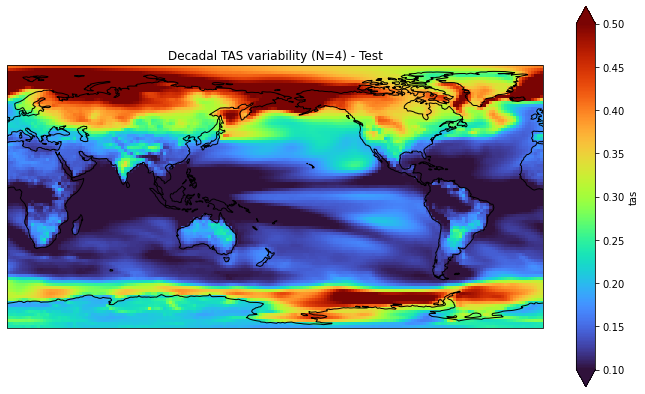

In [18]:
plt.rcParams['figure.figsize'] = [12, 7]
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
#ax.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_var_test.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='turbo', vmin=0.1, vmax=0.5)
ax.coastlines(color='black', linewidth=1)
plt.title('Decadal TAS variability (N=4) - Test')

In [57]:
mod_noncv = linear_model.Lasso()

mod_noncv.fit(np.stack((tas_mean_train, prw_train, omega_train), axis=1), tas_var_train)

Lasso()

Now that we've fitted our model, we can do a prediction.

In [58]:
pred_noncv = mod_noncv.predict(np.stack((tas_mean_test, prw_test, omega_test), axis=1))

pred_unstack_noncv = np.reshape(pred_noncv, (-1, 179)) # Unstacking the prediction to make it 2D again

# Giving our prediction a set of coordinates
pred_map_noncv = xr.DataArray(pred_unstack_noncv, dims=['lat','lon'], coords={'lat':prw['lat'].values, 
                                                                              'lon':prw['lon'].values})

Text(0.5, 1.0, 'TAS 10 year variability - true (N=4)')

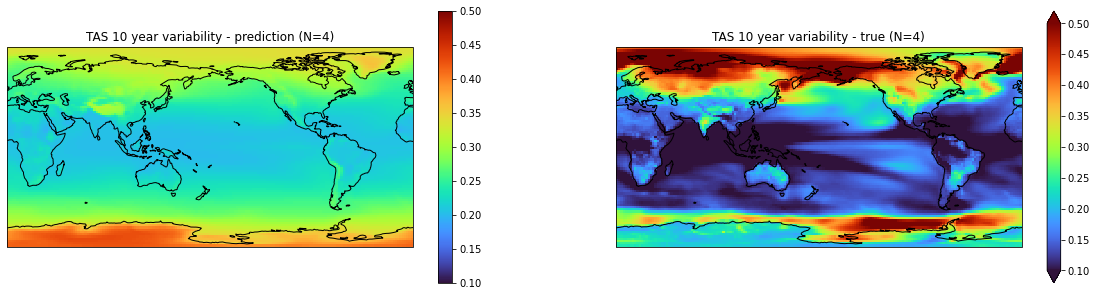

In [59]:
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

ax1 = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree(central_longitude=180))
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
pred_map_noncv.plot(ax=ax1, transform=ccrs.PlateCarree(),cmap='turbo', vmin=0.1, vmax=0.5)
ax1.coastlines(color='black', linewidth=1)
plt.title('TAS 10 year variability - prediction (N=4)')

ax2 = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree(central_longitude=180))
#ax2.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_var_test.unstack().plot(ax=ax2, transform=ccrs.PlateCarree(),cmap='turbo', vmin=0.1, vmax=0.5, cbar_kwargs={'label': ""})
ax2.coastlines(color='black', linewidth=1)
plt.title('TAS 10 year variability - true (N=4)')

This isn't a very good prediction.

In [61]:
mod_noncv.coef_

array([-0.00285721, -0.        , -0.        ])

The Lasso regression seems to have overcompensated and reduced the contributions of PRW and $\omega$ to zero. I'm going to attempt to mitigate this by using LassoCV, which performs iterative fitting and chooses the best model by cross-validation.

In [63]:
mod = linear_model.LassoCV(cv=3) # 3-fold cross-validation

mod.fit(np.stack((tas_mean_train, prw_train, omega_train), axis=1), tas_var_train)

LassoCV(cv=3)

In [64]:
pred = mod.predict(np.stack((tas_mean_test, prw_test, omega_test), axis=1))

pred_unstack = np.reshape(pred, (-1, 179)) # Unstacking the prediction to make it 2D again

# Giving our prediction a set of coordinates
pred_map = xr.DataArray(pred_unstack, dims=['lat','lon'], coords={'lat':prw['lat'].values, 'lon':prw['lon'].values})

Text(0.5, 1.0, 'TAS 10 year variability - true (N=4)')

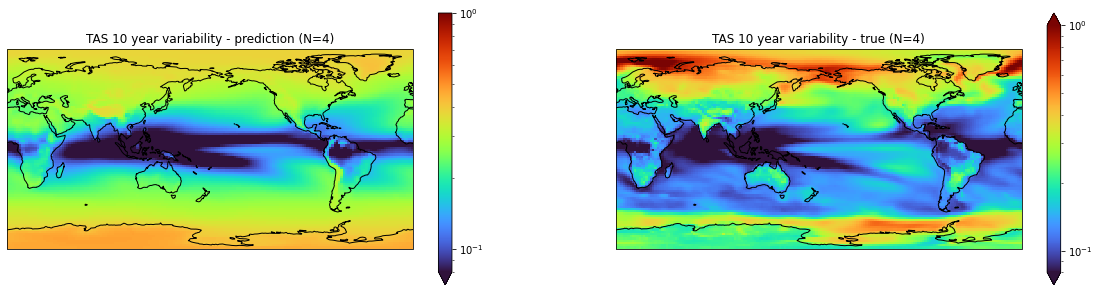

In [72]:
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

ax1 = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree(central_longitude=180))
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
pred_map.plot(ax=ax1, transform=ccrs.PlateCarree(),cmap='turbo',  vmin=8*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': ""})
ax1.coastlines(color='black', linewidth=1)
plt.title('TAS 10 year variability - prediction (N=4)')

ax2 = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree(central_longitude=180))
#ax2.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_var_test.unstack().plot(ax=ax2, transform=ccrs.PlateCarree(),cmap='turbo', vmin=8*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': ""})
ax2.coastlines(color='black', linewidth=1)
plt.title('TAS 10 year variability - true (N=4)')

In [73]:
mod.coef_

array([-0.00202865, -0.00532552, -0.        ])

While the poles are off (most likely due to sea-ice interactions that we can't replicate with PRW and $\omega$), our pattern is otherwise somewhat well replicated.

To see if we can get a better prediction and which variables are driving the pattern the most, we'll be fitting several models using only two of the variables:
 - PRW and TAS
 - PRW and $\omega$
 - TAS and $\omega$

In [75]:
# TAS and PRW
mod_tas_prw = linear_model.LassoCV(cv=3)

mod_tas_prw.fit(np.stack((tas_mean_train, prw_train), axis=1), tas_var_train)

# TAS and Omega
mod_tas_omega = linear_model.LassoCV(cv=3)

mod_tas_omega.fit(np.stack((tas_mean_train, omega_train), axis=1), tas_var_train)

# Omega and PRW
mod_prw_omega = linear_model.LassoCV(cv=3)

mod_prw_omega.fit(np.stack((prw_train, omega_train), axis=1), tas_var_train)

LassoCV(cv=3)

In [76]:
# Predictions


pred_tas_prw = mod_tas_prw.predict(np.stack((tas_mean_test, prw_test), axis=1))
pred_unstack_tas_prw = np.reshape(pred_tas_prw, (-1, 179)) 
pred_map_tas_prw = xr.DataArray(pred_unstack_tas_prw, dims=['lat','lon'], coords={'lat':prw['lat'].values, 
                                                                                  'lon':prw['lon'].values})

pred_tas_omega = mod_tas_omega.predict(np.stack((tas_mean_test, omega_test), axis=1))
pred_unstack_tas_omega = np.reshape(pred_tas_omega, (-1, 179)) 
pred_map_tas_omega = xr.DataArray(pred_unstack_tas_omega, dims=['lat','lon'], coords={'lat':prw['lat'].values, 
                                                                                      'lon':prw['lon'].values})

pred_prw_omega = mod_prw_omega.predict(np.stack((prw_test, omega_test), axis=1))
pred_unstack_prw_omega = np.reshape(pred_prw_omega, (-1, 179)) 
pred_map_prw_omega = xr.DataArray(pred_unstack_prw_omega, dims=['lat','lon'], coords={'lat':prw['lat'].values, 
                                                                                      'lon':prw['lon'].values})

Text(0.5, 1.0, 'PRW + $\\omega$ Prediction (N=4)')

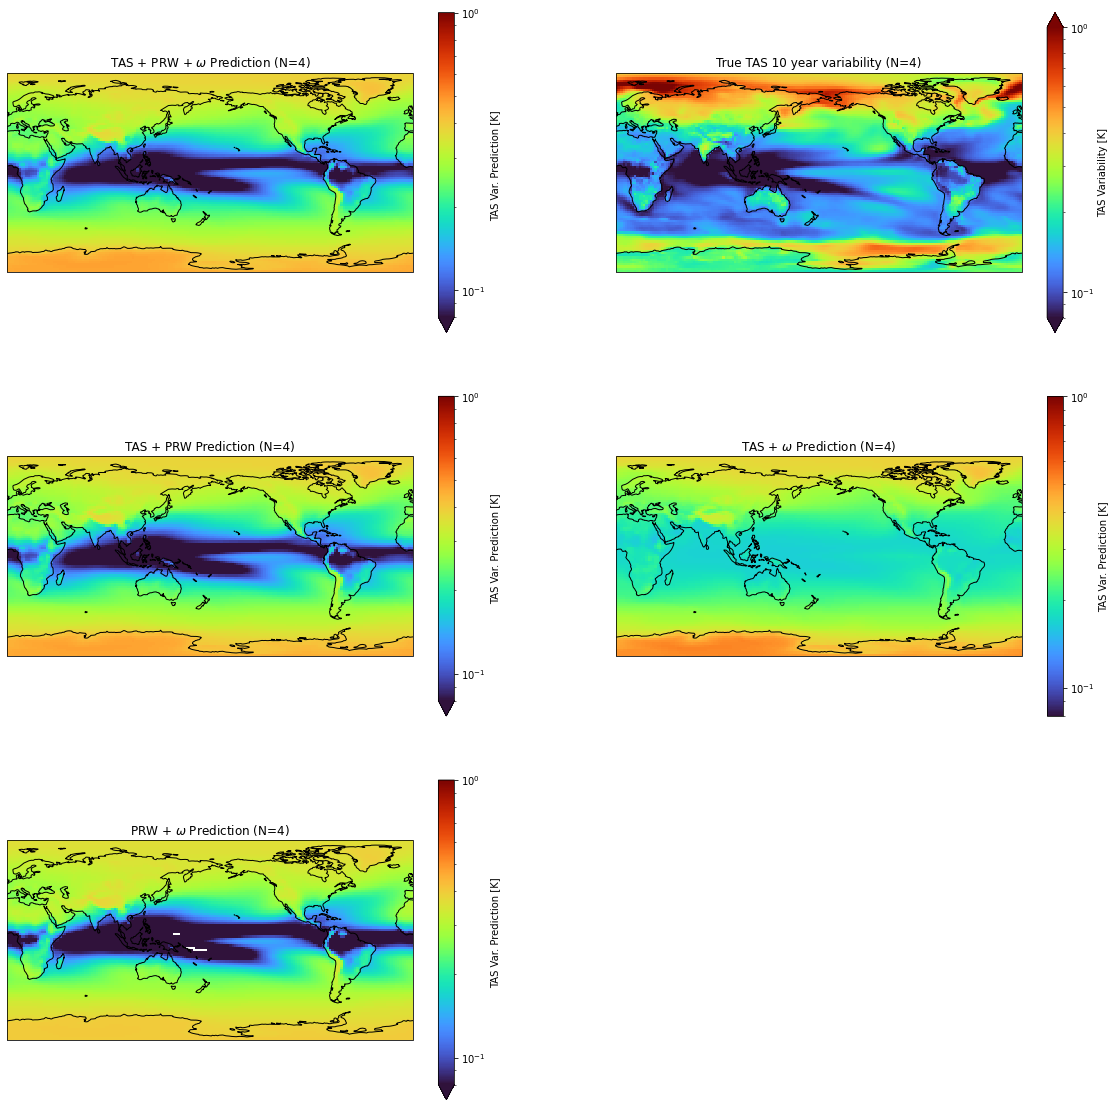

In [78]:
fig = plt.figure(figsize=(20,20))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

ax1 = fig.add_subplot(3,2,1, projection=ccrs.PlateCarree(central_longitude=180))
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
pred_map.plot(ax=ax1, transform=ccrs.PlateCarree(),cmap='turbo', vmin=8*10e-3, vmax=1, 
              norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': "TAS Var. Prediction [K]"})
ax1.coastlines(color='black', linewidth=1)
plt.title(r'TAS + PRW + $\omega$ Prediction (N=4)')

ax2 = fig.add_subplot(3,2,2, projection=ccrs.PlateCarree(central_longitude=180))
#ax2.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_var_test.unstack().plot(ax=ax2, transform=ccrs.PlateCarree(),cmap='turbo', vmin=8*10e-3, vmax=1, 
                            norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': "TAS Variability [K]"})
ax2.coastlines(color='black', linewidth=1)
plt.title('True TAS 10 year variability (N=4)')

ax3 = fig.add_subplot(3,2,3, projection=ccrs.PlateCarree(central_longitude=180))
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
pred_map_tas_prw.plot(ax=ax3, transform=ccrs.PlateCarree(),cmap='turbo', vmin=8*10e-3, vmax=1, 
                      norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': "TAS Var. Prediction [K]"})
ax3.coastlines(color='black', linewidth=1)
plt.title('TAS + PRW Prediction (N=4)')

ax4 = fig.add_subplot(3,2,4, projection=ccrs.PlateCarree(central_longitude=180))
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
pred_map_tas_omega.plot(ax=ax4, transform=ccrs.PlateCarree(),cmap='turbo', vmin=8*10e-3, vmax=1, 
                        norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': "TAS Var. Prediction [K]"})
ax4.coastlines(color='black', linewidth=1)
plt.title(r'TAS + $\omega$ Prediction (N=4)')

ax5 = fig.add_subplot(3,2,5, projection=ccrs.PlateCarree(central_longitude=180))
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
pred_map_prw_omega.plot(ax=ax5, transform=ccrs.PlateCarree(),cmap='turbo',  vmin=8*10e-3, vmax=1, 
                        norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': "TAS Var. Prediction [K]"})
ax5.coastlines(color='black', linewidth=1)
plt.title(r'PRW + $\omega$ Prediction (N=4)')



PRW seems to be the dominant factor driving our predictions being able to replicate the decadal variability patterns. On the other hand, $\omega$ and TAS together produce a somewhat homogeneous pattern, indicating that they aren't vital to the prediction of decadal TAS variability like PRW is.

# Testing + Evaluation

Importing metrics in order to analyze the errors in our regression.

In [79]:
from sklearn import metrics

Metrics for our model with all 3 predictors.

In [80]:
# Mean squared error

print("Mean squared error: {}".format(metrics.mean_squared_error(pred_map, tas_var_test)))

Mean squared error: 0.017159327316536126


In [81]:
# Mean absolute error

print("Mean absolute error: {}".format(metrics.mean_absolute_error(pred_map, tas_var_test)))

Mean absolute error: 0.09168647083756365


To get a better sense of the relationship these variables all have to TAS variability, I plotted scatter plots of TAS, PRW, and Omega with TAS variability.

15752


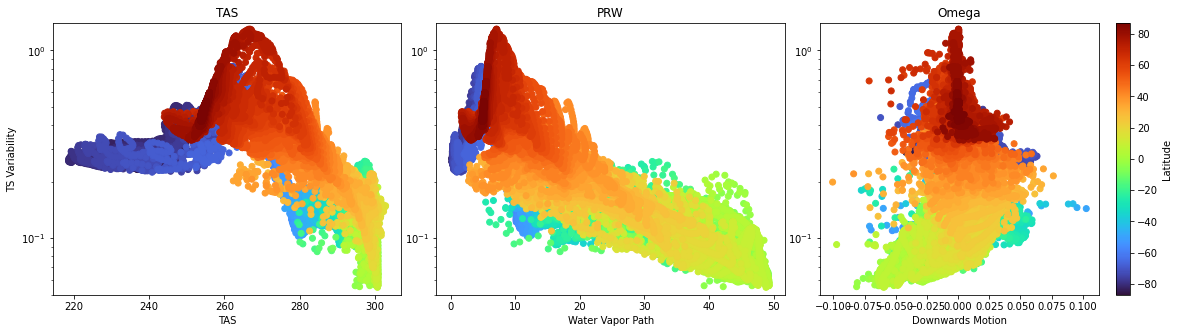

In [72]:
colored_lats = []
for latitude in tas_mean['lat'].values:
    for i in range(179): #length of longitude
       colored_lats.append(latitude)
print(len(colored_lats))

fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.1)


ax1 = fig.add_subplot(gs[0])
scatter = ax1.scatter(tas_mean_train,tas_var_train,c=colored_lats,cmap='turbo')
cbar = plt.colorbar(scatter, ax=ax1)
cbar.ax.set_ylabel('Latitude')
cbar.remove()
plt.title('TAS')
plt.xlabel('TAS')
plt.ylim(5*10**-2, 1.4)
plt.yscale('log')
plt.ylabel('TS Variability')

ax2 = fig.add_subplot(gs[1])
scatter = ax2.scatter(prw_train,tas_var_train,c=colored_lats,cmap='turbo')
cbar = plt.colorbar(scatter, ax=ax2)
cbar.ax.set_ylabel('Latitude')
cbar.remove()
plt.title('PRW')
plt.xlabel('Water Vapor Path')
plt.ylim(5*10**-2, 1.4)
plt.yscale('log')
#plt.ylabel('TS Variability')

ax3 = fig.add_subplot(gs[2])
scatter = ax3.scatter(omega_train,tas_var_train,c=colored_lats,cmap='turbo')
cbar = plt.colorbar(scatter, ax=ax3)
cbar.ax.set_ylabel('Latitude')
plt.title('Omega')
plt.xlabel('Downwards Motion')
plt.ylim(5*10**-2, 1.4)
plt.yscale('log')
#plt.ylabel('TS Variability')

# Redo with poles removed

Since the model may suffer due to sea ice interactions at the poles, here's an additional analysis I did of just within the tropics and extratropics. 

In [82]:
# Input data
tas_mean_eq = tas_trunc.mean('time').sel(lat=slice(-60,60))
tas_mean_stack_eq = tas_mean_eq.stack(z=('lat','lon'))

prw_mean_eq = prw_trunc.mean('time').sel(lat=slice(-60,60))
prw_stack_eq = prw_mean_eq.stack(z=('lat','lon'))

omega_mean_eq = omega_trunc.mean('time').sel(lat=slice(-60,60))
omega_stack_eq = omega_mean_eq.stack(z=('lat','lon'))

# Output data
tas_var_stack_eq = tas_var.sel(lat=slice(-60,60)).stack(z=('lat','lon'))

In [83]:
# Training data
tas_mean_train_eq = tas_mean_stack_eq.sel(name=train_mod).mean('name')
prw_train_eq = prw_stack_eq.sel(name=train_mod).mean('name')
omega_train_eq = omega_stack_eq.sel(name=train_mod).mean('name')
tas_var_train_eq = tas_var_stack_eq.sel(name=train_mod).mean('name')

# Test data
tas_mean_test_eq = tas_mean_stack_eq.sel(name=test_mod).mean('name')
prw_test_eq = prw_stack_eq.sel(name=test_mod).mean('name')
omega_test_eq = omega_stack_eq.sel(name=test_mod).mean('name')
# We don't have to pass this thru the model, so it's still a 2D array
tas_var_test_eq = tas_var.sel(lat=slice(-60,60)).sel(name=test_mod).mean('name') 

In [84]:
mod_eq = linear_model.LassoCV(cv=3)

mod_eq.fit(np.stack((tas_mean_train_eq, prw_train_eq, omega_train_eq), axis=1), tas_var_train_eq)

LassoCV(cv=3)

In [85]:
pred_eq = mod_eq.predict(np.stack((tas_mean_test_eq, prw_test_eq, omega_test_eq), axis=1))

pred_unstack_eq = np.reshape(pred_eq, (-1, 179)) # Unstacking the prediction to make it 2D again

# Giving our prediction a set of coordinates
pred_map_eq = xr.DataArray(pred_unstack_eq, dims=['lat','lon'], coords={'lat':prw_mean_eq['lat'].values, 
                                                                        'lon':prw_mean_eq['lon'].values})

Text(0.5, 1.0, 'TAS 10 year variability - true (N=4)')

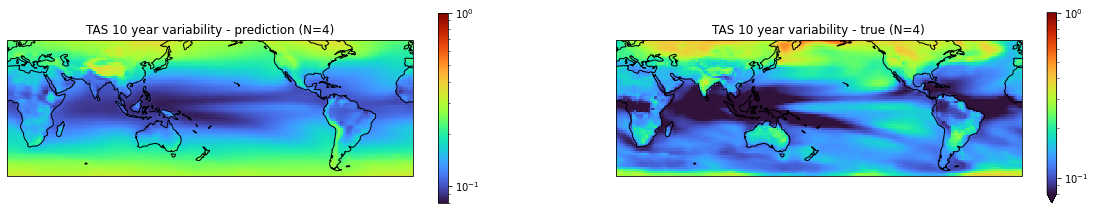

In [87]:
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.1)

ax1 = fig.add_subplot(1,2,1, projection=ccrs.PlateCarree(central_longitude=180))
#ax1.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
pred_map_eq.plot(ax=ax1, transform=ccrs.PlateCarree(),cmap='turbo',  vmin=8*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': "", 'shrink':0.7})
ax1.coastlines(color='black', linewidth=1)
plt.title('TAS 10 year variability - prediction (N=4)')

ax2 = fig.add_subplot(1,2,2, projection=ccrs.PlateCarree(central_longitude=180))
#ax2.add_feature(cart.feature.LAND, zorder=10, edgecolor='k')
tas_var_test_eq.unstack().plot(ax=ax2, transform=ccrs.PlateCarree(),cmap='turbo',  vmin=8*10e-3, vmax=1, 
                   norm=matplotlib.colors.LogNorm(), cbar_kwargs={'label': "", 'shrink':0.7})
ax2.coastlines(color='black', linewidth=1)
plt.title('TAS 10 year variability - true (N=4)')